# SHAP Features Tool Overview

This notebook outlines basic use of the 'SHAP' Python package to analyse Machine Model models, in terms of determinign feature signifance. 

Model interpretation is the key value gained from this tool.

## What are SHAP Features?

**Model Interpretation**

Historically, interpretability of feature importance has been straightforward with linear models. Often the goal is to understand the parametric value associated with a given feature. The higher the value, the greater its impact on the overall model at a global level. This is useful, but is limited in value across the tapestry of Machine Learning techniques. SHAP is a tool / approach that intends to aid in this generic interpretation.




**SHAP - Game Theory Basis**

This technique is based on game theory, lets start with an overview of the key beats of this in particular:

A group of people are playing a game. As a result of playing this game, they receive a certain reward; how can they divide this reward between themselves in a way which reflects each of their contributions? They would follow rules like so:

1. The sum of what everyone receives should equal the total reward
2. If two people contributed the same value, then they should receive the same amount from the reward
3. Someone who contributed no value should receive nothing
4. If the group plays two games, then an individual’s reward from both games should equal their reward from their first game plus their reward from the second game

In a machine learning problem, the reward is the final prediction of the complex model, and the participants in the game are features.

**The Shapley Equation**

At a very high level, what this equation does is calculate what the prediction of the model would be without feature i, calculate the prediction of the model with feature i, and then calculate the difference.

It does this by constructing my sets S. These are all possible combinations of  features, from which we can derive the importance of a given feature in N dimension feature input spaces.

You can imagine the granularity in difference will have high variance in models such as nueral networks, due to what is often a numeric output.

Note: You can also imagine in certain algorithms that the feature is encountered first may have the highest weighting / bias. For example as the splitting attribute in a decesion tree. The construction of sets of sets resolves this bias.

The SHAP library introduces optimisations to make the calculation of SHAP values more effecient, so the brute force approach does not exactly occur in practice but is good to reason with.

## Depedencies

In [122]:
! pip install shap
! pip install xgboost
! pip install pandas
! pip install sklearn
! pip install tensorflow as tf
! pip install xgboost

In [0]:
from xgboost import XGBClassifier
import sklearn
import pandas as pd
import shap
import tensorflow as tf 
from tensorflow.keras.preprocessing import text
from sklearn.preprocessing import LabelEncoder

## Data Acquisition & Preparation

The dataset is stock, irrelevant in this columnar experiment.

In [152]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url)

# Add Column Names
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
130,7.9,3.8,6.4,2.0,Iris-virginica
74,6.6,3.0,4.4,1.4,Iris-versicolor
80,5.5,2.4,3.7,1.0,Iris-versicolor
67,6.2,2.2,4.5,1.5,Iris-versicolor
28,4.7,3.2,1.6,0.2,Iris-setosa


## Create XGB Model


In [153]:
labels = df['species']
data = df[['sepal_length','sepal_width', 'petal_length', 'petal_width']]

train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(data, labels, random_state=2)

model = XGBClassifier()
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Create SHAP Tree Explainer & Demonstrate Plotting

In [154]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In the next code cell below, you can see that the SHAP explanation can be acquired on a class by class basis, through selecting the appropriate index. 

The data structure of shap_values is such that each class is a list, within each of those lists is a list of SHAP values for each training data instance. Representing the core coeffecients for each feature that impacted the classification during training.

**Explanation**

The 'output value' is the prediction for that observation.

The 'Base Value' is the value that would be predicted if we did not know any features for the current output. Its the mean model output.

Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue. These represent 'forces'

The larger the segment associated with a feature, the greater impact it has had on the models output value.

In [155]:
class_selection_by_index = 1
instance_index_selection = 25

shap.initjs()
shap.force_plot(explainer.expected_value[class_selection_by_index], shap_values[class_selection_by_index][instance_index_selection], 
                train_data.iloc[instance_index_selection])

**Explanation**

The top X axis is each data point in the training set. 

The three classes are distributed across the range of the model output value, with class label in specific bins of that range.

Each different class has a different degree of feature force, in combination. Your can see that 'petal_length' is a key discrimintory feature between at least two of the classes.

In the X value of '50' you can see 'sepal_length' tries to push the feature combination into a higher model output value, but the strength of the other features ensures a consensus classification.

You can think of each 'Y' as a individual force plot as seen in the prior example.

In [128]:
shap.initjs()
shap.force_plot(explainer.expected_value[class_selection_by_index], shap_values[class_selection_by_index], train_data)

**Explanation**

Shap auto selects another feature to show interaction with our target feature with another, in this example the 'sepal_length' was selected by SHAP.

The two feature values for each data point are plotted. 

This plot shows that for petal length there are three clear groupings of shap values. 

A first grouping of petal length has a negative shap value (blue) which mean this is opposing the target class in the first grouping.

The second grouping of moderate petal lengths show that this length typical has a mixed impact on class assignment, showing that it could be hindering the model as it influences the target class positively and negatively depending on the instance.

The final grouping tells us that the higher petal length almost always has a positive contribution to a target class (seen by mainly red's).

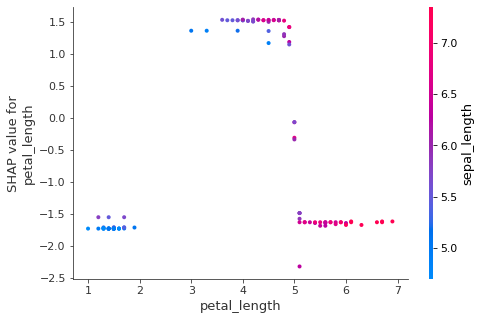

In [156]:
feature_to_plot = 'petal_length'
shap.initjs()
shap.dependence_plot(feature_to_plot, shap_values[class_selection_by_index], train_data)

**Explanation**

The plot shows which features are important for each class.

In the case of 'sepal_width' we can see that it only impacts class two assignment in any notable way.

While 'petal_length' has a key impact on all of the class assignments.

Given its higher shap value, it is in general the most important variable in the dataset.

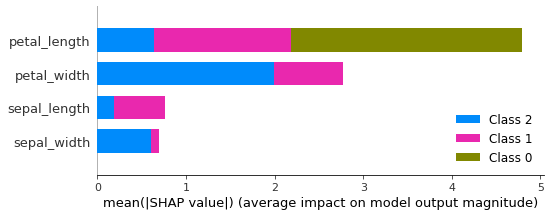

In [157]:
shap.initjs()
shap.summary_plot(shap_values, train_data)

**Explanation**

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.

This plot shows the most important feature for this class in order.

The Y points represent every SHAP value associated with a prediciton, showing if it has a role in a positive or negative contribution to the target variable. 

We can tell sepal_width is not discriminatory for this class.

For each point associated with the 'petal_length' we can see that it has a high degree of important at its value poles. Indicating its a key discrimintory variable for this class.

If you change the index to '0' you will see that 'petal_length' is the only feature which is key for determining the class.



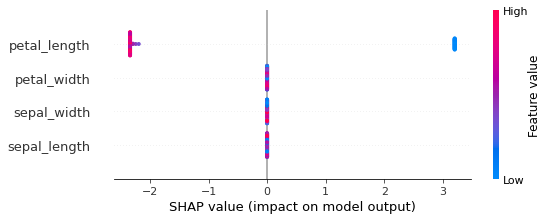

In [160]:
shap.initjs()
shap.summary_plot(shap_values[class_selection_by_index], train_data)

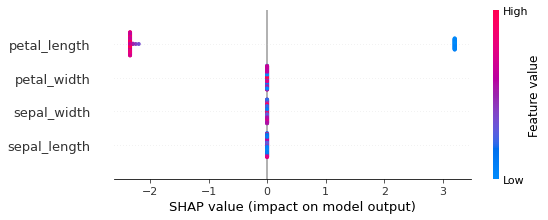

In [161]:
shap.initjs()
shap.summary_plot(shap_values[0], train_data)

## SHAP Kernel Explainer (Any Model Type)

Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model

It uses test data to get SHAP values, this differs from the training of a tree.

In [132]:
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(train_data, train_labels)

explainer = shap.KernelExplainer(svm.predict_proba, train_data, link="logit")
shap_values = explainer.shap_values(test_data)

Using 111 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [162]:
# plot the SHAP values for the output of the indexed instance
shap.initjs()
shap.force_plot(explainer.expected_value[class_selection_by_index], shap_values[class_selection_by_index][instance_index_selection,:], test_data.iloc[instance_index_selection,:], link="logit")

## NLP SHAP'ing

### Text Data Load

In [134]:
uri="sample_data/spam.csv"
df = pd.read_csv(uri, encoding = "ISO-8859-1")

# Drop dangling columns and rename remainer to human readable terms.
df = df[["v1", "v2"]]
df.columns = ["label", "text"]

df.sample(5)

,label,text
32,ham,K tell me anything about you.
3538,ham,What happen dear. Why you silent. I am tensed
197,ham,is your hamster dead? Hey so tmr i meet you at...
4846,ham,I am in escape theatre now. . Going to watch K...
1374,spam,"500 New Mobiles from 2004, MUST GO! Txt: NOKIA..."


### Prepare Data for Modelling

In [0]:
VOCAB_SIZE = 400
NUM_OUTPUTS = 2

Label encode our targets.


In [136]:
LE = LabelEncoder()
df['code'] = LE.fit_transform(df['label'])
df.sample(5)

,label,text,code
3967,ham,Did u turn on the heater? The heater was on an...,0
4494,ham,Hope this text meets you smiling. If not then ...,0
4507,ham,Not able to do anything.,0
712,spam,08714712388 between 10am-7pm Cost 10p,1
4662,ham,No. Yes please. Been swimming?,0


Split our data into training and testing sets

In [0]:
data = df['text']
labels = df['code']
train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(data, labels)

Tokenise and generate BOW - basic one hot encoding array.

In a comment I have a tokenizer with no vocabulary limit, this will need changed in tandem with the size of the NN's first layer later if you want to use all the words. For more info, see limitations.


In [0]:
tokenizer = text.Tokenizer(num_words=VOCAB_SIZE)
# tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(train_data)

bag_of_words_train = tokenizer.texts_to_matrix(train_data)
bag_of_words_test = tokenizer.texts_to_matrix(test_data)

### Modelling

Define the architecture of a basic neural network to accept len(BOW) and output num_classes.

Use sparse crossentropy loss function when there are two or more label classes. Expect labels to be provided as integers.

In [0]:
# bag_of_words_vector_len = len(bag_of_words_train[0])

In [0]:
# Define Neural Network.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, input_shape=(VOCAB_SIZE,), activation='relu'))
# model.add(tf.keras.layers.Dense(50, input_shape=(bag_of_words_vector_len,), activation='relu'))
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_OUTPUTS, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

What Does our Model Look Like?

In [140]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 50)                20050     
_________________________________________________________________
dense_16 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 52        
Total params: 21,377
Trainable params: 21,377
Non-trainable params: 0
_________________________________________________________________


Train our model...

In [141]:
model.fit(bag_of_words_train, train_labels, epochs=3, batch_size=32, validation_split=0.1)

Epoch 1/3
118/118 [==============================] - 0s 3ms/step - loss: 0.3908 - accuracy: 0.8599 - val_loss: 0.1452 - val_accuracy: 0.9569
Epoch 2/3
118/118 [==============================] - 0s 2ms/step - loss: 0.0815 - accuracy: 0.9827 - val_loss: 0.0399 - val_accuracy: 0.9833
Epoch 3/3
118/118 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9910 - val_loss: 0.0372 - val_accuracy: 0.9880


Is our Model any good?

In [142]:
model.evaluate(bag_of_words_test, test_labels, batch_size=32)

44/44 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9777


[0.09322290122509003, 0.9777458906173706]

### SHAP Analysis

Setup our SHAP explainer object.


In [0]:
explainer = shap.DeepExplainer(model, bag_of_words_train)

Then we’ll get the attribution values for N individual predictions.


In [0]:
NUM_PREDICTIONS = 10
shap_vals = explainer.shap_values(bag_of_words_test[:NUM_PREDICTIONS])

### Get Words in Vocabulary

Get all the words in the dataset, for reference later.

In [0]:
words = tokenizer.word_index

word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup

What features have the greatest impact on the classification?

We can see 'is' and 'you' are indidactors of HAM while 'year' and 'tonight' are SPAM orientated, however due to the data imbalance, this is only part of the picture.

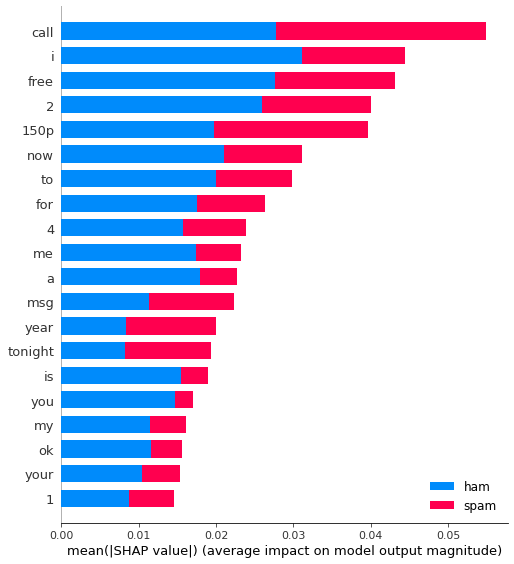

In [146]:
shap.initjs()
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=LE.classes_)

For a given class, discover the impact of the features on the model output for each time the word occurs for this class.

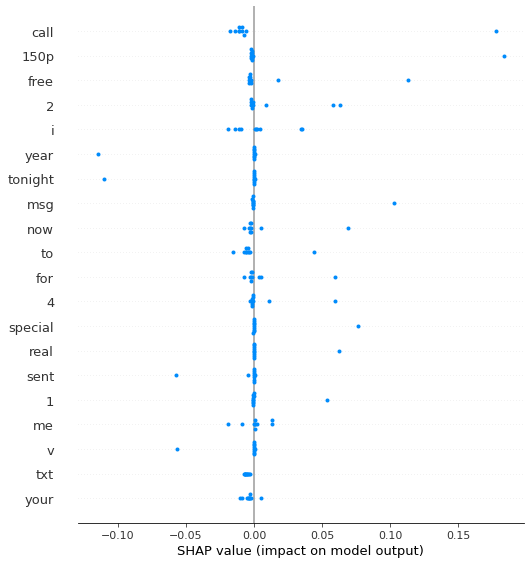

In [164]:
class_selection_by_index = 1

shap.initjs()
shap.summary_plot(shap_vals[class_selection_by_index], feature_names=word_lookup, class_names=LE.classes_)

Show the SHAP Values for a single predicition. See limitations on why the labels are binary values, rather than text.

We can see here a sequence of features drive the model value output down, influencing the class assignment.

In [148]:
instance_index_selection = 2

shap.initjs()
shap.force_plot(float(explainer.expected_value[class_selection_by_index]), 
                shap_vals[class_selection_by_index][instance_index_selection], 
                bag_of_words_test[instance_index_selection])

## Limitations




- The combinatory use of the Keras Tokenizer and SHAP makes it difficult to use a limited volcabulary in order to visualise the originals words represented within the BOW data structure. There is no clear conversion from BOW to text items in the Tokensier, which leads to showing in SHAP plots the BOW one hot values. 
  - If you remove the restriction of a limited vocabulary this would lead to plotting a graph of with too many possible variables, SHAP does not render this correctly. 
  - Ordering the word counts from the Tokeniser is potentially feasible but its is not trivial to determine if the order of each instance in the BOW corresponds to a word frequency order of the text to enable this. 
  - To this end, I have accepted the limitations and showed the results as is.
  - It is possible to use other tooling in future (Not Keras, at least this verion of it) to enable easier retrieval of the original words from a BOW vector

